In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding # This line is not needed

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import pandas as pd

train_dir = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        # Use concat to add a new row to the dataframe
        train_df = pd.concat([train_df, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        # Use concat to add a new row to the dataframe
        test_df = pd.concat([test_df, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

,image_path,label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,0
1,/content/drive/MyDrive/Skin cancer ISIC The In...,0
2,/content/drive/MyDrive/Skin cancer ISIC The In...,0
3,/content/drive/MyDrive/Skin cancer ISIC The In...,0
4,/content/drive/MyDrive/Skin cancer ISIC The In...,0
...,...,...
2351,/content/drive/MyDrive/Skin cancer ISIC The In...,8
2352,/content/drive/MyDrive/Skin cancer ISIC The In...,8
2353,/content/drive/MyDrive/Skin cancer ISIC The In...,8
2354,/content/drive/MyDrive/Skin cancer ISIC The In...,8


In [6]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'dermatofibroma',
 1: 'actinic keratosis',
 2: 'pigmented benign keratosis',
 3: 'vascular lesion',
 4: 'melanoma',
 5: 'nevus',
 6: 'squamous cell carcinoma',
 7: 'seborrheic keratosis',
 8: 'basal cell carcinoma'}

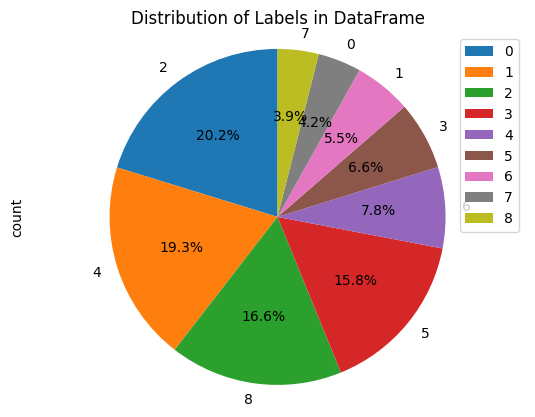

In [7]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [8]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               dermatofibroma                 98        
1               actinic keratosis              130       
2               pigmented benign keratosis     477       
3               vascular lesion                155       
4               melanoma                       454       
5               nevus                          373       
6               squamous cell carcinoma        184       
7               seborrheic keratosis           93        
8               basal cell carcinoma           392       
------------------------------------------------------------
Total                                         2356      


In [9]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

In [10]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [11]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

96

In [12]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

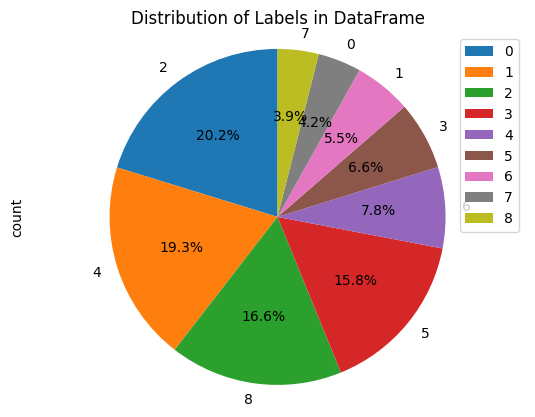

In [13]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [14]:
df.head()

,image_path,label,image
0,/content/drive/MyDrive/Skin cancer ISIC The In...,0,"[[[205, 185, 188], [206, 185, 188], [205, 185,..."
1,/content/drive/MyDrive/Skin cancer ISIC The In...,0,"[[[195, 162, 185], [194, 160, 181], [196, 164,..."
2,/content/drive/MyDrive/Skin cancer ISIC The In...,0,"[[[232, 175, 189], [230, 166, 182], [231, 169,..."
3,/content/drive/MyDrive/Skin cancer ISIC The In...,0,"[[[169, 138, 131], [171, 140, 135], [175, 144,..."
4,/content/drive/MyDrive/Skin cancer ISIC The In...,0,"[[[215, 172, 181], [216, 174, 181], [216, 177,..."


In [15]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               dermatofibroma                 98        
1               actinic keratosis              130       
2               pigmented benign keratosis     477       
3               vascular lesion                155       
4               melanoma                       454       
5               nevus                          373       
6               squamous cell carcinoma        184       
7               seborrheic keratosis           93        
8               basal cell carcinoma           392       
------------------------------------------------------------
Total                                         2356      


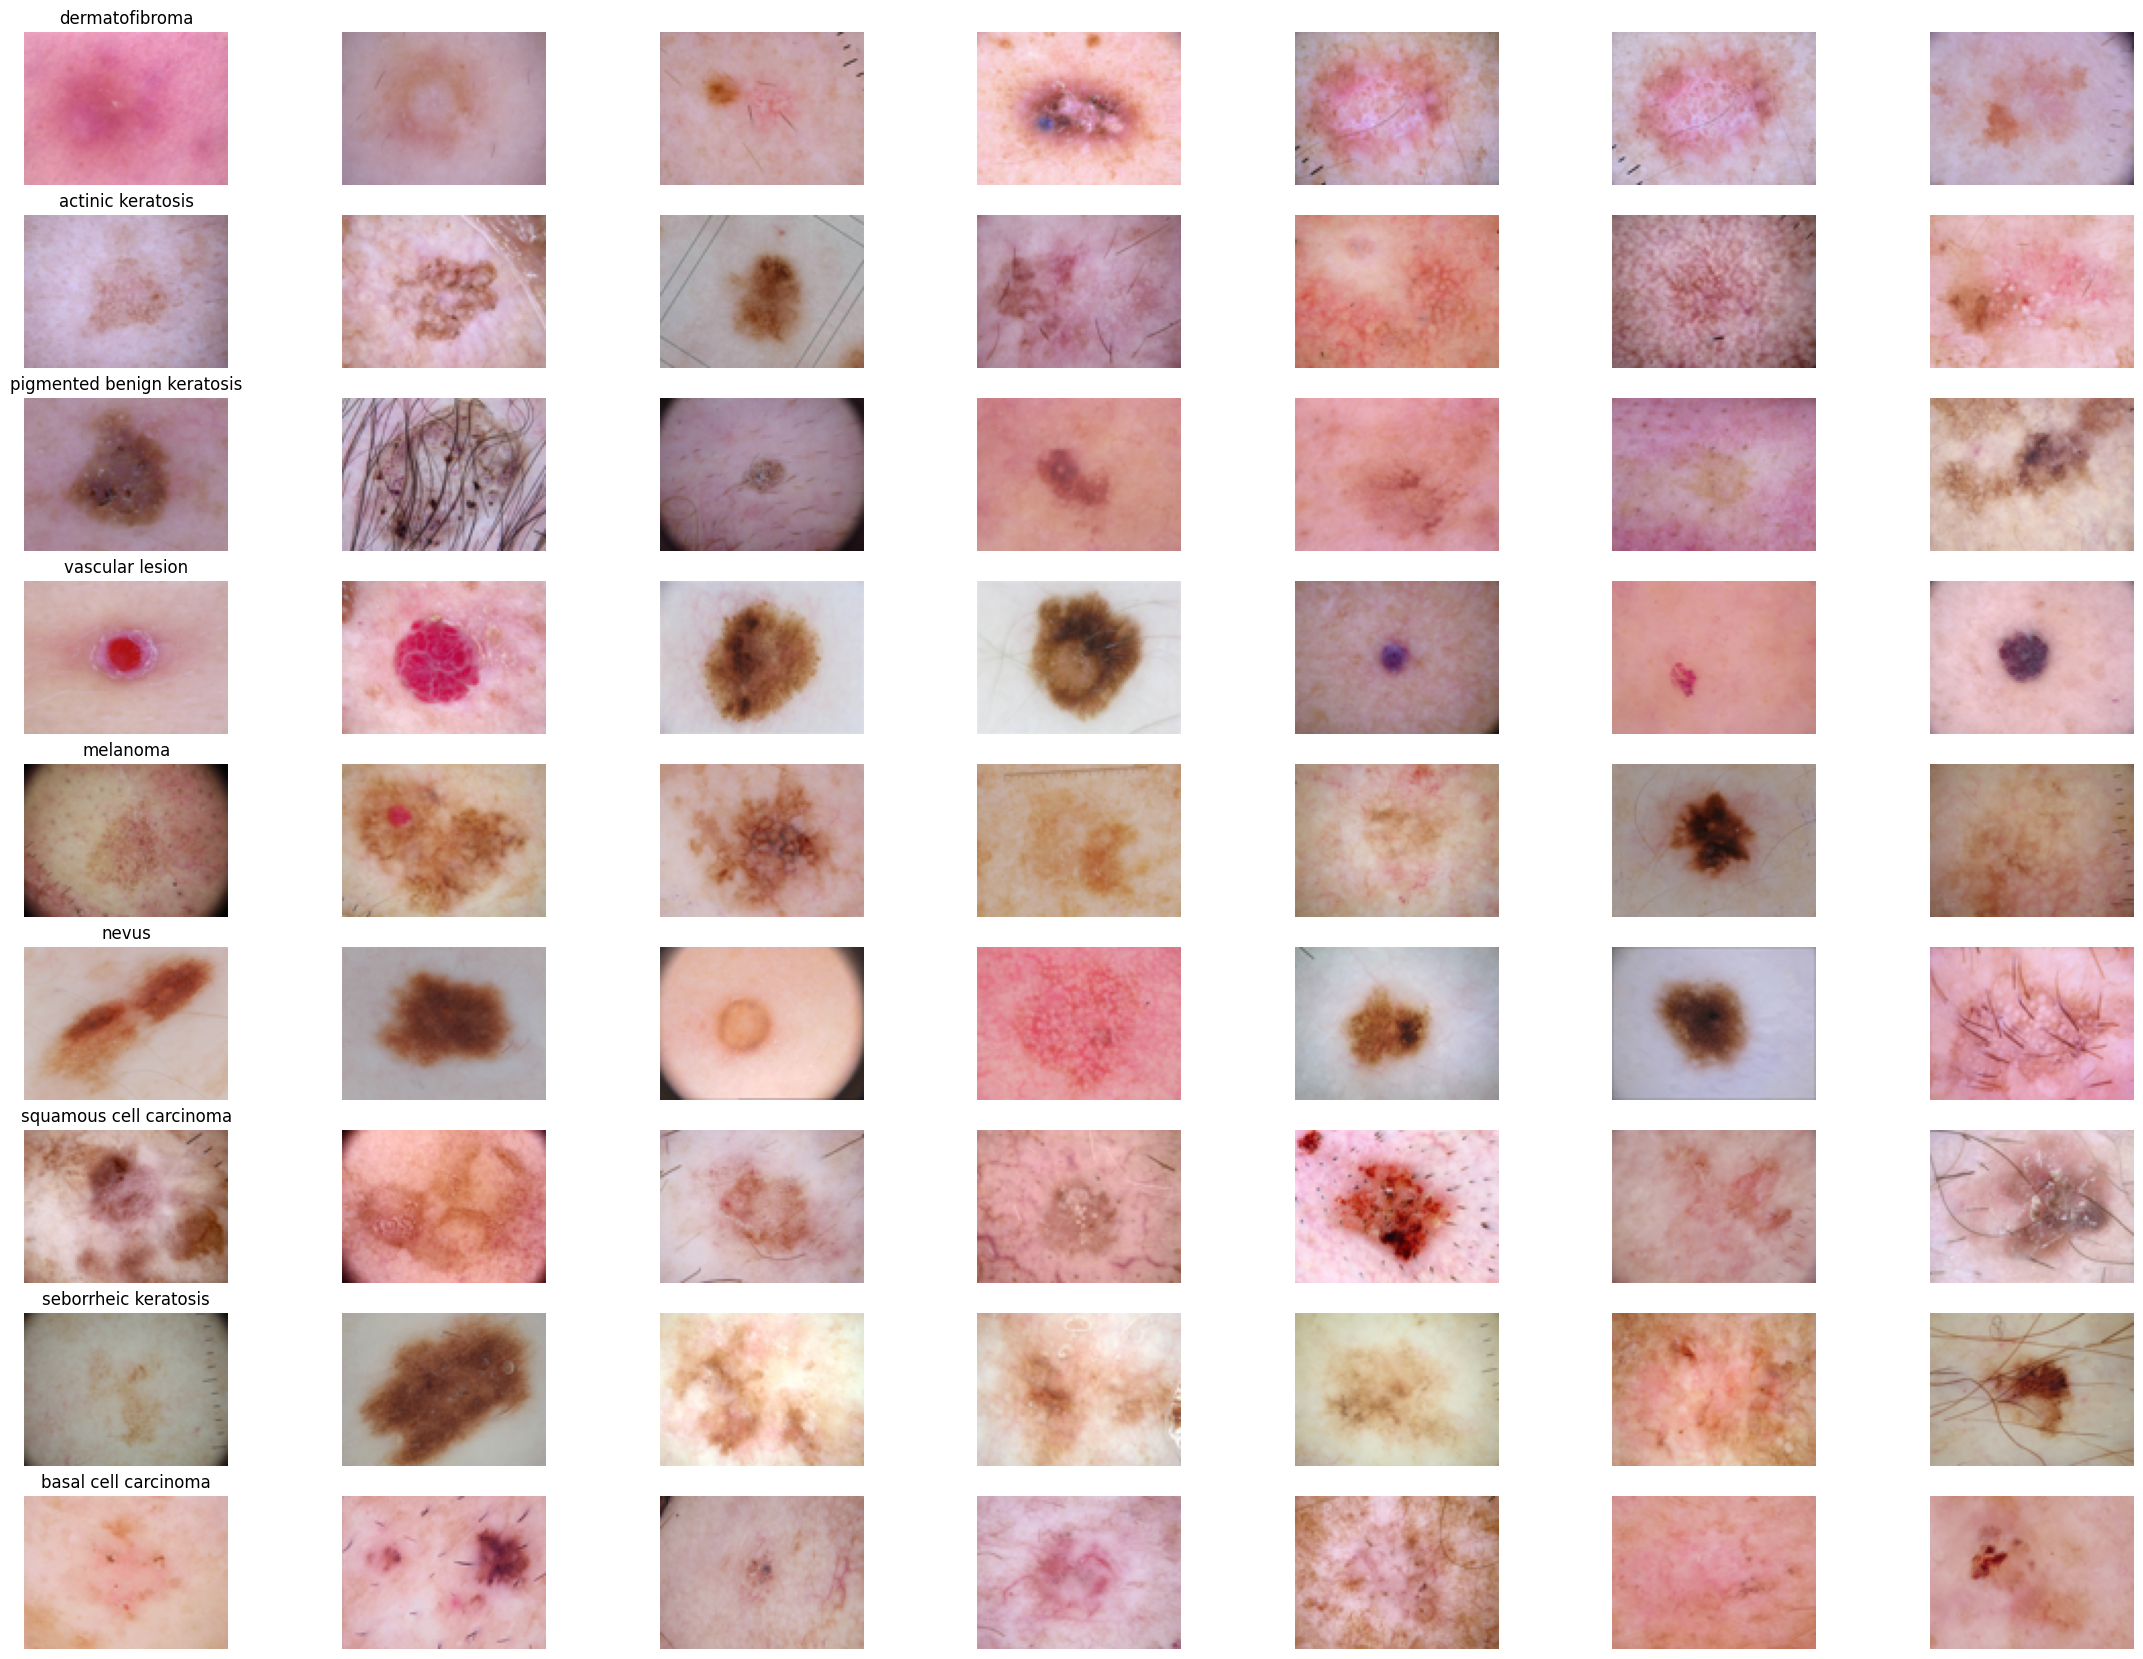

In [16]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [17]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2356
Name: count, dtype: int64

In [53]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [54]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values

    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)

    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)

            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                # Use concat instead of append to add new row to dataframe
                augmented_df = pd.concat([augmented_df, pd.DataFrame({'image_path': [None], 'label': [class_label], 'image': [augmented_image_array]})], ignore_index=True)

    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    # Use concat instead of append to add new row to dataframe
    augmented_df = pd.concat([augmented_df, original_images_df], ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [55]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               dermatofibroma                 2500      
1               actinic keratosis              2500      
2               pigmented benign keratosis     2500      
3               vascular lesion                2500      
4               melanoma                       2500      
5               nevus                          2500      
6               squamous cell carcinoma        2500      
7               seborrheic keratosis           2500      
8               basal cell carcinoma           2500      
------------------------------------------------------------
Total                                         22500     


In [56]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [57]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [58]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [59]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [60]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [61]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.20,shuffle=True)

In [62]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [63]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [64]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               dermatofibroma                 1601       395          504        2500      
1               actinic keratosis              1644       384          472        2500      
2               pigmented benign keratosis     1599       394          507        2500      
3               vascular lesion                1566       413          521        2500      
4               melanoma                       1586       429          485        2500      
5               nevus                          1646       377          477        2500      
6               squamous cell carcinoma        1607       380          513        2500      
7               seborrheic keratosis           1551       

In [65]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [66]:
input_shape = df['image'][0].shape

In [67]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [68]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from datetime import datetime

In [69]:
model_DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
model1 = Sequential()
for layer in model_DenseNet201.layers:
        layer.trainable = False
model1.add(model_DenseNet201)
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten_2 (Flatten)         (None, 11520)             0         
                                                                 
 dropout_2 (Dropout)         (None, 11520)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               5898752   
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)               

In [70]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.0001, momentum=0.9)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

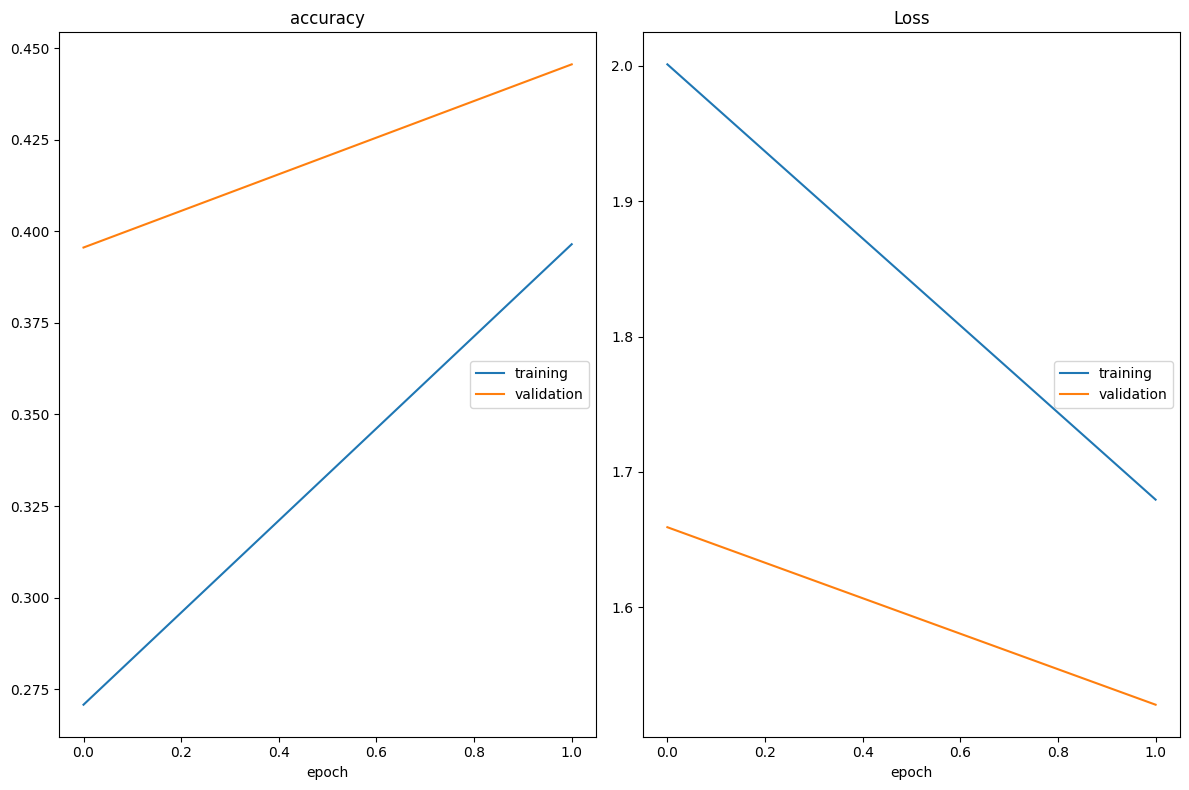

accuracy
	training         	 (min:    0.271, max:    0.396, cur:    0.396)
	validation       	 (min:    0.396, max:    0.446, cur:    0.446)
Loss
	training         	 (min:    1.680, max:    2.001, cur:    1.680)
	validation       	 (min:    1.528, max:    1.659, cur:    1.528)
450/450 [==============================] - 122s 272ms/step - loss: 1.6795 - accuracy: 0.3965 - val_loss: 1.5281 - val_accuracy: 0.4456
Training Time:  0:04:20.330484


In [71]:
# Fit the model
start = datetime.now()
history = model1.fit(x=x_train,
                    y=y_train,
                    epochs=2,
                    validation_split=0.2,
                    batch_size=32,
                    validation_data=(x_validate,y_validate),
                    callbacks=[PlotLossesKeras()]
                   )
stop = datetime.now() - start
print("Training Time: ",stop)

In [72]:
loss, accuracy = model1.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 93s 206ms/step - loss: 1.4794 - accuracy: 0.4602
Train: accuracy = 0.460208  ;  loss = 1.479371


In [73]:
loss, accuracy = model1.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 32s 206ms/step - loss: 1.4857 - accuracy: 0.4611
Testing: accuracy = 0.461111  ;  loss = 1.485692


141/141 [==============================] - 33s 207ms/step


<Axes: >

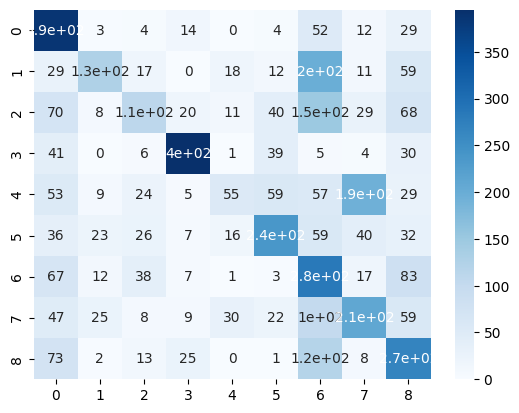

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model1.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.4611
Precision: 0.4921
Recall: 0.4574
F1-score: 0.4435
Kappa score: 0.3930


In [76]:
from sklearn.metrics import classification_report

y_pred = model1.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

141/141 [==============================] - 28s 200ms/step
              precision    recall  f1-score   support

           0       0.48      0.77      0.59       504
           1       0.61      0.27      0.38       472
           2       0.45      0.22      0.29       507
           3       0.82      0.76      0.79       521
           4       0.42      0.11      0.18       485
           5       0.57      0.50      0.53       477
           6       0.28      0.56      0.37       513
           7       0.40      0.41      0.41       512
           8       0.41      0.52      0.46       509

    accuracy                           0.46      4500
   macro avg       0.49      0.46      0.44      4500
weighted avg       0.49      0.46      0.45      4500



In [77]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [78]:
model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model2 = Sequential()
for layer in model_VGG16.layers:
    layer.trainable = False
model2.add(model_VGG16)
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dropout_3 (Dropout)         (None, 3072)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               1573376   
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)               

In [79]:
from tensorflow.keras.optimizers import SGD
# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

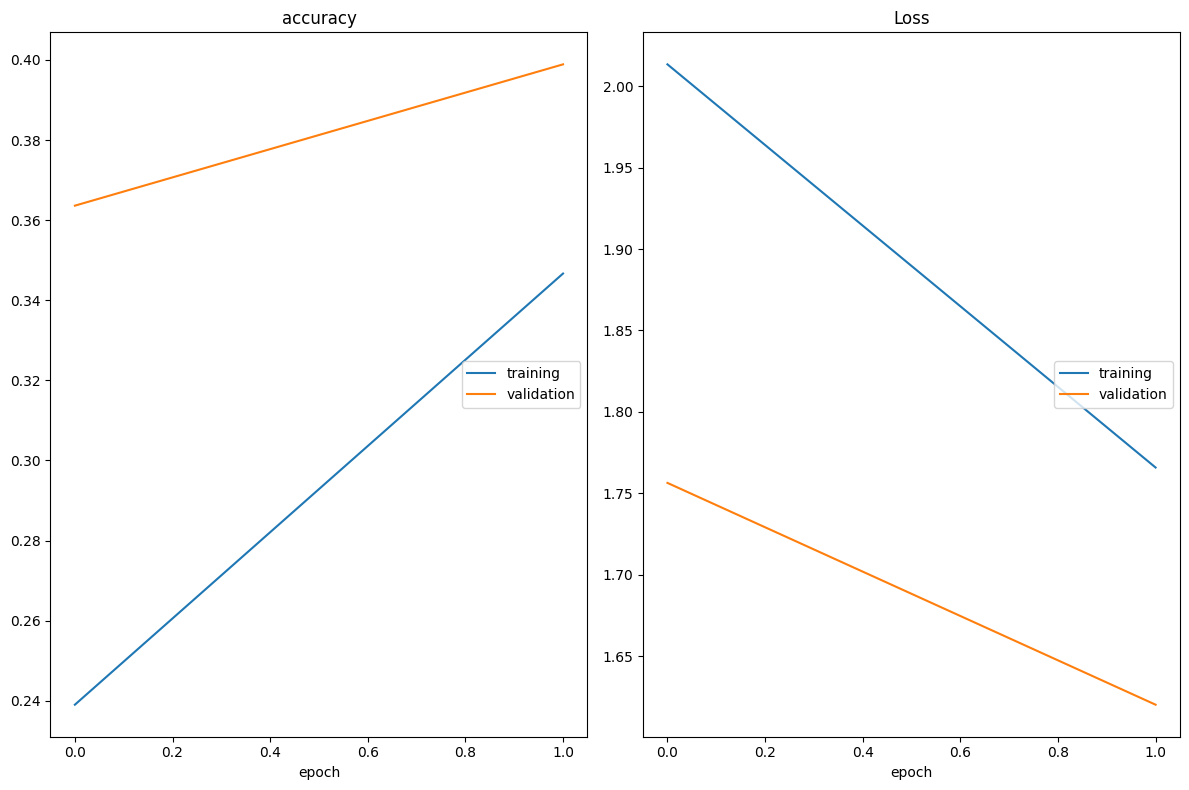

accuracy
	training         	 (min:    0.239, max:    0.347, cur:    0.347)
	validation       	 (min:    0.364, max:    0.399, cur:    0.399)
Loss
	training         	 (min:    1.766, max:    2.013, cur:    1.766)
	validation       	 (min:    1.620, max:    1.756, cur:    1.620)
450/450 [==============================] - 63s 140ms/step - loss: 1.7658 - accuracy: 0.3467 - val_loss: 1.6201 - val_accuracy: 0.3989


In [80]:
# Fit the model
history = model2.fit(x=x_train,
                    y=y_train,
                    validation_split=0.2,
                    batch_size=32,
                    epochs=2,
                    validation_data=(x_validate, y_validate),
                    callbacks=[PlotLossesKeras()])

In [81]:
loss, accuracy = model2.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 50s 112ms/step - loss: 1.5823 - accuracy: 0.4251
Train: accuracy = 0.425139  ;  loss = 1.582295


In [82]:
loss, accuracy = model2.evaluate(x_test, y_test, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 16s 111ms/step - loss: 1.6007 - accuracy: 0.4160
Train: accuracy = 0.416000  ;  loss = 1.600726


141/141 [==============================] - 16s 111ms/step


<Axes: >

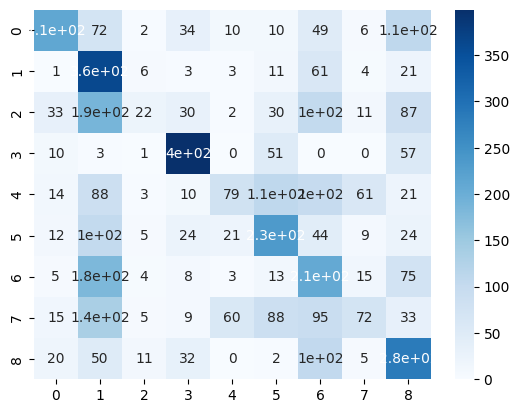

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model2.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.4160
Precision: 0.4443
Recall: 0.4171
F1-score: 0.3852
Kappa score: 0.3436


In [85]:
from sklearn.metrics import classification_report

y_pred = model2.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

141/141 [==============================] - 15s 108ms/step
              precision    recall  f1-score   support

           0       0.66      0.42      0.51       504
           1       0.31      0.77      0.44       472
           2       0.37      0.04      0.08       507
           3       0.73      0.77      0.75       521
           4       0.44      0.16      0.24       485
           5       0.43      0.49      0.46       477
           6       0.27      0.41      0.33       513
           7       0.39      0.14      0.21       512
           8       0.40      0.56      0.47       509

    accuracy                           0.42      4500
   macro avg       0.44      0.42      0.39      4500
weighted avg       0.45      0.42      0.39      4500



In [86]:
def predict_single(model, x_random, y_random, label_map):
    predictions = model.predict(x_random)
    for i in range(len(x_random)):
        print(f"Actual: {label_map[np.argmax(y_random[i])]}")
        print(f"Predicted: {label_map[np.argmax(predictions[i])]}")
        print()

In [87]:
import random

random_indices = random.sample(range(len(x_test)), 6)
x_random = x_test[random_indices]
y_random = y_test[random_indices]

print("DenseNet201")
predict_single(model1, x_random, y_random, label_map)

DenseNet201
1/1 [==============================] - 0s 124ms/step
Actual: pigmented benign keratosis
Predicted: basal cell carcinoma

Actual: melanoma
Predicted: basal cell carcinoma

Actual: squamous cell carcinoma
Predicted: squamous cell carcinoma

Actual: squamous cell carcinoma
Predicted: pigmented benign keratosis

Actual: pigmented benign keratosis
Predicted: dermatofibroma

Actual: seborrheic keratosis
Predicted: seborrheic keratosis



In [88]:
random_indices = random.sample(range(len(x_test)), 6)
x_random = x_test[random_indices]
y_random = y_test[random_indices]

print("VGG16")
predict_single(model2, x_random, y_random, label_map)

VGG16
1/1 [==============================] - 0s 65ms/step
Actual: basal cell carcinoma
Predicted: squamous cell carcinoma

Actual: vascular lesion
Predicted: vascular lesion

Actual: basal cell carcinoma
Predicted: vascular lesion

Actual: nevus
Predicted: squamous cell carcinoma

Actual: squamous cell carcinoma
Predicted: actinic keratosis

Actual: vascular lesion
Predicted: vascular lesion

